# TUTORIAL : INTRODUCTING TORCHGAN
**Author** - [Aniket Das](https://aniket1998.github.io)

**[Try this tutorial on colab](https://colab.research.google.com/drive/19rDnX2VF9BW94AG48UbZp5btkv5KT2eo)**

This tutorial introduces you to the basics of [TorchGAN](https://github.com/torchgan/torchgan) to define, train and evaluate **Generative Adversarial Networks** easily in 
**PyTorch**. This tutorial mainly explores the library's core features, the predefined losses and the models. TorchGAN is designed to be highly and very easily extendable and at the end of the tutorial, we see how seamlessly you can integrate your own custom losses and models into the API's training loop

This tutorial assumes that your system has **PyTorch** and **TorchGan** installed properly. If not, head over to the installation instructions on the [official documentation website](https://torchgan.readthedocs.io/en/latest/).

## IMPORTS

In [ ]:
# General Imports
import os
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML
# Pytorch and Torchvision Imports
import torch
import torch.nn as nn
import torchvision
from torch.optim import Adam
import torch.nn as nn
import torch.utils.data as data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils
# Torchgan Imports
import torchgan
from torchgan.models import *
from torchgan.losses import *
from torchgan.trainer import Trainer

In [4]:
# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  999


## DATA LOADING AND PREPROCESSING
This tutorial uses the **MNIST** dataset for illustration purposes and convergence time issues. We apply the following transformations to the raw dataset to speed up training
1. MNIST digits have a size of $28 \times 28$ by default. The default models present in **TorchGAN** assume that the image dimensions are a perfect power of 2 (though this behavior can be very easily overriden). For the purposes of this tutorial where we use the default models out of the box, we rescale the images to $32 \times 32$
2. The images are normalized with a mean and standard deviation of 0.5 for each channel. This has been observed to enable easier training (one can also choose to normalize with the per channel mean and standard deviation)

We then wrap the dataset in a **DataLoader**. This is done because **TorchGAN Trainer** , which shall be explored in later sections requires said DataLoader to be passed as a parameter while training

In [ ]:
dataset = dsets.MNIST(root='./mnist', train=True,
                      transform=transforms.Compose([transforms.Resize((32, 32)),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(mean = (0.5, ), std = (0.5, ))]),
                      download=True)

In [ ]:
dataloader = data.DataLoader(dataset, batch_size=64, shuffle=True)

## NETWORK ARCHITECTURE : DCGAN
This tutorial uses the highly popular Deep Convolutional GAN or DCGAN architecture. **TorchGAN** provides a generalised implementation of DCGAN out of the box. 

### GENERATOR NETWORK
The DCGAN Generator receives an input noise vector of size $batch\ size \times encoding\ dims$. It outputs a tensor of $batch\ size \times 1 \times 32 \times 32$ corresponding to a batch of generated image samples. The generator transforms the noise vector into images in the following manner
1. **Channel Dimension**: $encoding\ dims \rightarrow d \rightarrow \frac{d}{2} \rightarrow \frac{d}{4} \rightarrow 1$.
2. **Image size**: $(1 \times 1) \rightarrow (4 \times 4) \rightarrow (8 \times 8) \rightarrow (16 \times 16) \rightarrow (32 \times 32)$.

The intermediate layers use the **Leaky ReLU** activation function  as ReLU tends to kill gradients and critically slow down convergence. One can also use activation functions such as **ELU** or any other activation of choice that ensures good gradient flow. The last layer uses a $ tanh $ activation in order to constrain the pixel values in the range $(-1 \to 1)$ . One can easily change the nonlinearity of the intermediate and the last layers as per their preference by passing them as parameters during initialization of the Generator object. 

### DISCRIMINATOR NETWORK
The DCGAN discriminator has an architecture symmetric to the generator. It maps the image to a confidence score in order to classify whether the image is real (i.e. comes from the dataset) or fake (i. e. sampled by the generator)

For reasons same as above we use a **Leaky ReLU** activation. The conversion of the image tensor to the confidence scores are as follows:

1. **Channel Dimension**: $1 \rightarrow d \rightarrow 2 \times d \rightarrow 4 \times d \rightarrow 1$.
2. **Image size**: $(32 \times 32) \rightarrow (16 \times 16) \rightarrow (8 \times 8) \rightarrow (4 \times 4) \rightarrow (1 \times 1)$.

*Note: The last layer of the discriminator in most standard implementations of DCGAN have a Sigmoid layer that causes the confidence scores to lie in the interval $(0 \to 1)$ and allows the easy interpretation of the confidence score as the probability of the image being real. However, this interpretation is only restricted to the Minimax Loss proposed in the original GAN paper and losses such as the Wasserstein Loss do not require such an interpretation. If required, however, one can easily set the activation of the last layer to Sigmoid by passing it as a parameter during initialization time*

## OPTIMIZERS AND HYPERPARAMETERS

The models, their corresponding optimizers and other hyperparameters like the nonlinearities to be used in the intermediate layers are bundled in the form of a dictionary and provided to the trainer for instantiation. The dictionary specifies the models that are to be trained, the optimizers associated with said models and learning rate schedulers, if any


1. "name": The class name for the model. Generally a subclass of the ```torchgan.models.Generator``` or ```torchgan.models.Discriminator```
2. "args": Arguments fed into the class during instantiation, into its constructor 
3. "optimizer": A dictionary containing the following key-value pairs defining the optimizer associated with the model
    * "name" : The class name of the optimizer. Generally an optimizer from the ```torch.optim``` package
    * "args" : Arguments to be fed to the optimizer during its instantiation, into its constructor
    * "var": Variable name for the optimizer. This is an optional argument. If this is not provided, we assign the optimizer the name ```optimizer_{}``` where {} refers to the variable name of the model.
    * "scheduler": Optional scheduler associated with the optimizer. Again this is a dictionary with the following keys
        * "name" : Class name of the scheduler
        * "args" : Arguments to be provided to the scheduler during instantiation, into its constructor
        
This tutorial shows the example for a DCGAN optimized by the Adam optimizer. Head over to the documentation of ```DCGANGenerator``` , ```DCGANDiscriminator``` or the ```torch.optim.Adam``` classes for more details about what each of the args mean (*NB: The args are basically parameters to the constructor of each class declared in "name" , as discussed before* ). Also try tinkering with the various hyperparameters like *"encoding_dims", "step_channels", "nonlinearity" and "last_nonlinearity"*

In [ ]:
dcgan_network = {
    "generator": {
        "name": DCGANGenerator,
        "args": {
            "encoding_dims": 100,
            "out_channels": 1,
            "step_channels": 32,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.Tanh()
        },
        "optimizer": {
            "name": Adam,
            "args": {
                "lr": 0.0001,
                "betas": (0.5, 0.999)
            }
        }
    },
    "discriminator": {
        "name": DCGANDiscriminator,
        "args": {
            "in_channels": 1,
            "step_channels": 32,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.LeakyReLU(0.2)
        },
        "optimizer": {
            "name": Adam,
            "args": {
                "lr": 0.0003,
                "betas": (0.5, 0.999)
            }
        }
    }
}

## LOSS FUNCTIONS
**TorchGAN** provides a wide variety of GAN losses and penalties off the shelf. One can also easily implement custom losses and integrate it with the highly robust training pipeline

1. Minimax Loss
2. Wasserstein GAN with Gradient Penalty
3. Least Squares GAN or LSGAN


The loss objects to be used by the trainer are added in a list as shown

In [ ]:
minimax_losses = [MinimaxGeneratorLoss(), MinimaxDiscriminatorLoss()]
wgangp_losses = [WassersteinGeneratorLoss(), WassersteinDiscriminatorLoss(), WassersteinGradientPenalty()]
lsgan_losses = [LeastSquaresGeneratorLoss(), LeastSquaresDiscriminatorLoss()]

## VISUALIZE THE TRAINING DATA

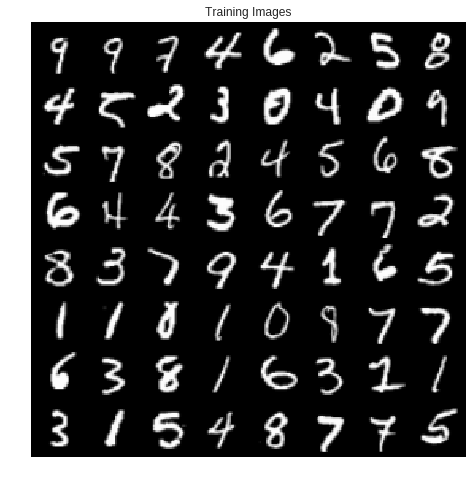

In [9]:
# Plot some of the training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## TRAINING THE NETWORK

*NB: Training the models are quite expensive. Hence we will train the models for **40** epochs if a GPU is available, else we will be training for only **5** epochs. We recommend using the **GPU runtime** in Colab. The images will not look even close to realistic in **5** epochs but shall be enough to show that it is learning to generate good quality images. *

---

The trainer is initialized by passing the network descriptors and the losses, and then calling the trainer on the dataset. 
The *sample_size* parameter decides how many images to sample for visualization at the end of every epoch, and the *epochs* parameter decides the number of epochs.
We illustrate the training process by training an LSGAN. Simply change the losses list passed from *lsgan_losses* to *wgangp_losses* to train a Wasserstein GAN with Gradient Penalty, or to *minimax_losses* to train a Minimax GAN

---

Important information for visualizing the performance of the GAN is printed to the console. We also provide a **Visualizer API** for visualizing the various losses, gradient flow and generated images. Setting up the Visualizer using either a **TensorboardX** or **Vizdom** backend is the recommended approach for visualizing the training process. 

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # Use deterministic cudnn algorithms
    torch.backends.cudnn.deterministic = True
    epochs = 40
else:
    device = torch.device("cpu")
    epochs = 5

print("Device: {}".format(device))
print("Epochs: {}".format(epochs))

Device: cuda:0
Epochs: 40


In [ ]:
trainer = Trainer(dcgan_network, lsgan_losses, sample_size=64, epochs=epochs, device=device)

In [12]:
trainer(dataloader)

Saving Model at './model/gan0.model'
Epoch 1 Summary
generator Mean Gradients : 3.3601897621992705
discriminator Mean Gradients : 12.766687169466184
Mean Running Discriminator Loss : 0.031985868796158126
Mean Running Generator Loss : 0.5773591010301098
Generating and Saving Images to ./images/epoch1_generator.png

Saving Model at './model/gan1.model'
Epoch 2 Summary
generator Mean Gradients : 1.871107902676975
discriminator Mean Gradients : 9.4076550166002
Mean Running Discriminator Loss : 0.01971807123669711
Mean Running Generator Loss : 0.5551951952707539
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
generator Mean Gradients : 1.2931722159886285
discriminator Mean Gradients : 8.156814747416435
Mean Running Discriminator Loss : 0.014949400106872887
Mean Running Generator Loss : 0.543896336301727
Generating and Saving Images to ./images/epoch3_generator.png

Saving Model at './model/gan3.model'
Epoch 4 Summary
genera

## VISUALIZING THE SAMPLES
Once training is complete, one can easily visualize the loss curves, gradient flow and sampled images per epoch on either the **TensorboardX** or **Vizdom** backends. For the purposes of this tutorial, we plot some of the sampled images here itself.

*NB: It is highly recommended to view the results on TensorboardX or Vizdom if you are running this tutorial locally*

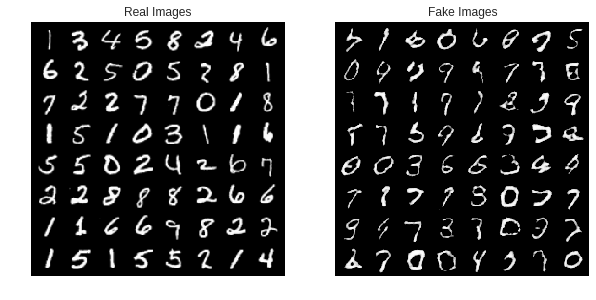

In [13]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, trainer.epochs)))
plt.show()


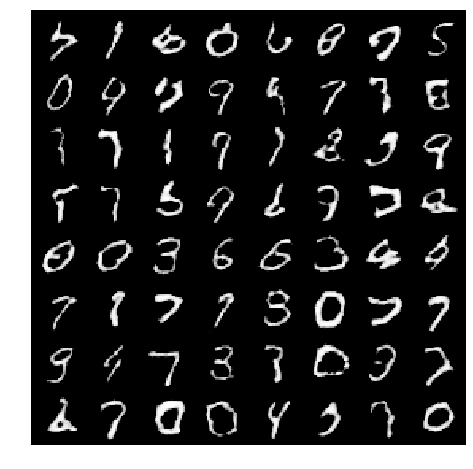

In [14]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, i)))] for i in range(1, trainer.epochs + 1)]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# Play the animation
HTML(ani.to_jshtml())

## TRAINING CONDITIONAL GAN MODELS
TorchGAN supports semi-supervised learning off the shelf through its Conditional GAN and Auxiliary Classifier GAN models and losses, that condition on the labels. Note that it is mandatory for the dataset to have labels for semi-supervised learning. We illustrate this by training a **Conditional DCGAN** on **MNIST**, conditioning the model on the identity of the digit

Generator and Discriminator architecture remain the same as that in DCGAN except the number of class labels has to be passed as an additional parameter in the dictionary defining the model.We reuse all the hyperparameters from the previous section

In [ ]:
cgan_network = {
    "generator": {
        "name": ConditionalGANGenerator,
        "args": {
            "encoding_dims": 100,
            "num_classes": 10, # MNIST digits range from 0 to 9
            "out_channels": 1,
            "step_channels": 32,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.Tanh()
        },
        "optimizer": {
            "name": Adam,
            "args": {
                "lr": 0.0001,
                "betas": (0.5, 0.999)
            }
        }
    },
    "discriminator": {
        "name": ConditionalGANDiscriminator,
        "args": {
            "num_classes": 10,
            "in_channels": 1,
            "step_channels": 32,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.Tanh()
        },
        "optimizer": {
            "name": Adam,
            "args": {
                "lr": 0.0003,
                "betas": (0.5, 0.999)
            }
        }
    }
}

## LOSS FUNCTIONS
We reuse the Least Squares loss used to train the DCGAN in the previous section 

In [ ]:
trainer_cgan = Trainer(cgan_network, lsgan_losses, sample_size=64, epochs=epochs, device=device)

In [ ]:
trainer_cgan(dataloader)

Saving Model at './model/gan0.model'
Epoch 1 Summary
generator Mean Gradients : 4.368147828282366
discriminator Mean Gradients : 19.74233446673385
Mean Running Discriminator Loss : 0.11738198800985493
Mean Running Generator Loss : 0.3841419988421044
Generating and Saving Images to ./images/epoch1_generator.png

Saving Model at './model/gan1.model'
Epoch 2 Summary
generator Mean Gradients : 3.8525348579278
discriminator Mean Gradients : 18.946872481907587
Mean Running Discriminator Loss : 0.12453533794039856
Mean Running Generator Loss : 0.3606796365728709
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
generator Mean Gradients : 4.161350921163297
discriminator Mean Gradients : 17.77558904480712
Mean Running Discriminator Loss : 0.11827323570656878
Mean Running Generator Loss : 0.36795843914369625
Generating and Saving Images to ./images/epoch3_generator.png



## VISUALIZING THE SAMPLES

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, trainer.epochs)))
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, i)))] for i in range(1, trainer.epochs + 1)]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# Play the animation
HTML(ani.to_jshtml())